# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

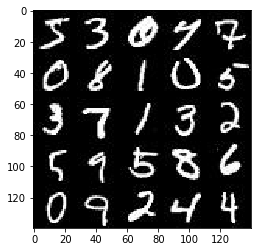

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

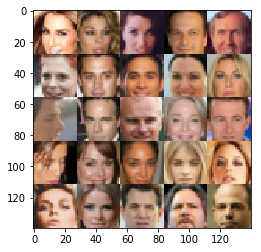

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # create placeholders for data and learn rate
    input_data = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_images")
    z_data = tf.placeholder(tf.float32, shape=(None, z_dim), name="z_data")
    lr = tf.placeholder(tf.float32, shape=(), name="learn_rate")

    return input_data, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(x, alpha):
    """
    leaky relu func as TF doesnt have a built in one
    """
    return tf.maximum(alpha * x, x)

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2    
   
    x = images    
    
    # use xavier to set weights to smaller amount
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    use_dropout = False
    
    with tf.variable_scope("discriminator", reuse=reuse): 
        
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        #x1 = tf.layers.batch_normalization(x1, training=True) # no batch norm on first layer
        x1 = leaky_relu(x1, alpha)
        if use_dropout:
            x1 = tf.nn.dropout(x1, 0.9)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = leaky_relu(x2, alpha)
        if use_dropout:
            x2 = tf.nn.dropout(x2, 0.9)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = leaky_relu(x3, alpha)
        if use_dropout:
            x3 = tf.nn.dropout(x3, 0.9)
    
        # tack on fc layer
        n_units = int(x3.shape[1] * x3.shape[2] * x3.shape[3])
        
        #flatten out
        fl = tf.reshape(x3, [-1, n_units])
        
        logits = tf.layers.dense(fl, 1)
        
        # sigmoid activation
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
   
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2
    
    reuse = not is_train  
    
    #use xavier for sensible weight init
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    alt_model_version = True
   
    with tf.variable_scope("generator", reuse=reuse):
    
        if alt_model_version:
            # flat input layer
            x1 = tf.layers.dense(z, 7*7*512)
            
            # reshape x1 to begin inverse convolution
            x1 = tf.reshape(x1, (-1, 7, 7, 512))
        
        else:
            # flat input layer
            x1 = tf.layers.dense(z, units=3*3*512, activation=None)
        
            # reshape x1 to begin inverse convolution
            x1 = tf.reshape(x1, (-1, 3, 3, 512))
            
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1, alpha)
        
        #print(x1.shape)
        
        if alt_model_version:
            x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=2, padding='same', kernel_initializer=kernel_init)
        else:
            x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='valid', kernel_initializer=kernel_init)
        
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2, alpha)
        
        #print(x2.shape)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same', kernel_initializer=kernel_init)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3, alpha)
        
        #print(x3.shape)
        
        # output layer...
        
        if alt_model_version:
            logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=1, padding='same')
        else:
            logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='same', kernel_initializer=kernel_init)
        
        
        #print(logits.shape)
      
        out = tf.nn.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    smooth = 0.1 # smooth the ones to help training per Udacity advice
    
    # Generator network:

    g_model = generator(input_z, out_channel_dim, is_train=True)


    # Disriminator network:
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # Calculate losses
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_logits_real) * (1-smooth)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_logits_real)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model    
    
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    #used to throttle output
    counter=0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Get images, reshape and rescale to pass to D
                counter = counter+1
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                
               
                if counter % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, {inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    

                if counter % 100 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4268... Generator Loss: 3.9635
Epoch 1/2... Discriminator Loss: 0.3559... Generator Loss: 4.8803
Epoch 1/2... Discriminator Loss: 0.3820... Generator Loss: 3.9810
Epoch 1/2... Discriminator Loss: 0.3537... Generator Loss: 5.4079
Epoch 1/2... Discriminator Loss: 0.3470... Generator Loss: 5.4028


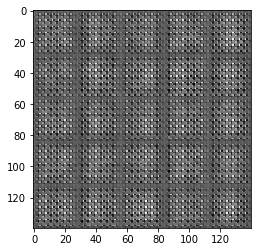

Epoch 1/2... Discriminator Loss: 0.3486... Generator Loss: 5.0852
Epoch 1/2... Discriminator Loss: 0.3444... Generator Loss: 5.8941
Epoch 1/2... Discriminator Loss: 0.3540... Generator Loss: 7.5677
Epoch 1/2... Discriminator Loss: 0.6580... Generator Loss: 2.3212
Epoch 1/2... Discriminator Loss: 0.8276... Generator Loss: 1.5185


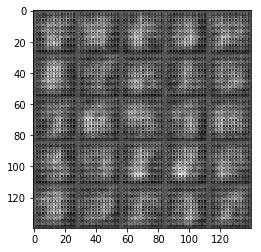

Epoch 1/2... Discriminator Loss: 0.5399... Generator Loss: 2.5986
Epoch 1/2... Discriminator Loss: 0.6316... Generator Loss: 1.9426
Epoch 1/2... Discriminator Loss: 0.6212... Generator Loss: 2.2751
Epoch 1/2... Discriminator Loss: 0.6804... Generator Loss: 1.8471
Epoch 1/2... Discriminator Loss: 0.6735... Generator Loss: 2.5180


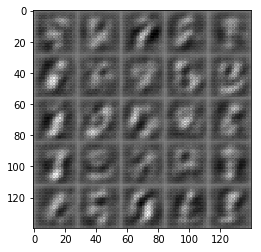

Epoch 1/2... Discriminator Loss: 0.5806... Generator Loss: 2.5263
Epoch 1/2... Discriminator Loss: 0.5308... Generator Loss: 3.0320
Epoch 1/2... Discriminator Loss: 0.4429... Generator Loss: 3.6375
Epoch 1/2... Discriminator Loss: 0.7900... Generator Loss: 2.6868
Epoch 1/2... Discriminator Loss: 0.6615... Generator Loss: 1.9193


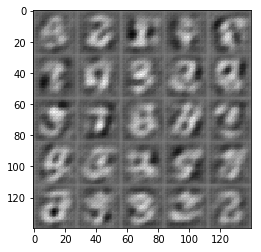

Epoch 1/2... Discriminator Loss: 0.4901... Generator Loss: 3.1751
Epoch 1/2... Discriminator Loss: 0.7027... Generator Loss: 1.9619
Epoch 1/2... Discriminator Loss: 0.4632... Generator Loss: 2.8460
Epoch 1/2... Discriminator Loss: 0.8020... Generator Loss: 1.8111
Epoch 1/2... Discriminator Loss: 0.4858... Generator Loss: 3.0719


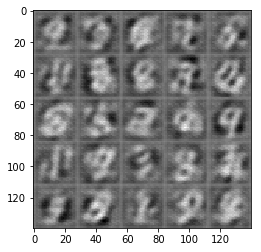

Epoch 1/2... Discriminator Loss: 0.6366... Generator Loss: 2.4489
Epoch 1/2... Discriminator Loss: 0.5515... Generator Loss: 2.5202
Epoch 1/2... Discriminator Loss: 0.9526... Generator Loss: 1.2820
Epoch 1/2... Discriminator Loss: 0.7482... Generator Loss: 1.6010
Epoch 1/2... Discriminator Loss: 0.5243... Generator Loss: 2.9537


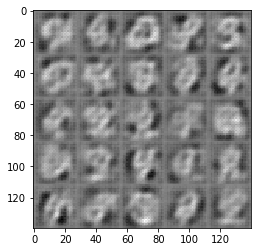

Epoch 1/2... Discriminator Loss: 0.6677... Generator Loss: 1.7782
Epoch 1/2... Discriminator Loss: 0.5268... Generator Loss: 2.9059
Epoch 1/2... Discriminator Loss: 0.7907... Generator Loss: 2.1059
Epoch 1/2... Discriminator Loss: 0.6900... Generator Loss: 2.4657
Epoch 1/2... Discriminator Loss: 0.6986... Generator Loss: 2.5700


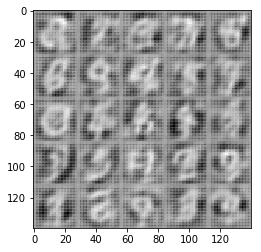

Epoch 1/2... Discriminator Loss: 0.6355... Generator Loss: 2.3593
Epoch 1/2... Discriminator Loss: 0.5653... Generator Loss: 2.9351
Epoch 1/2... Discriminator Loss: 0.6007... Generator Loss: 2.4855
Epoch 1/2... Discriminator Loss: 0.7717... Generator Loss: 1.9349
Epoch 1/2... Discriminator Loss: 0.5819... Generator Loss: 2.4065


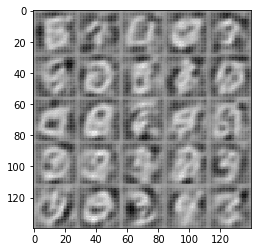

Epoch 1/2... Discriminator Loss: 0.6674... Generator Loss: 2.9113
Epoch 1/2... Discriminator Loss: 0.6960... Generator Loss: 1.6210
Epoch 1/2... Discriminator Loss: 0.6551... Generator Loss: 2.4516
Epoch 1/2... Discriminator Loss: 0.5258... Generator Loss: 2.4683
Epoch 1/2... Discriminator Loss: 0.6242... Generator Loss: 2.4205


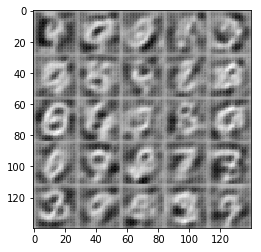

Epoch 1/2... Discriminator Loss: 0.5941... Generator Loss: 2.7028
Epoch 2/2... Discriminator Loss: 0.5724... Generator Loss: 1.9441
Epoch 2/2... Discriminator Loss: 0.6725... Generator Loss: 1.8022
Epoch 2/2... Discriminator Loss: 0.8350... Generator Loss: 2.0898
Epoch 2/2... Discriminator Loss: 0.6704... Generator Loss: 2.1036


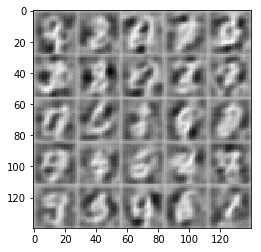

Epoch 2/2... Discriminator Loss: 0.6995... Generator Loss: 2.7359
Epoch 2/2... Discriminator Loss: 0.8138... Generator Loss: 1.9430
Epoch 2/2... Discriminator Loss: 0.7931... Generator Loss: 1.3273
Epoch 2/2... Discriminator Loss: 0.9242... Generator Loss: 1.3205
Epoch 2/2... Discriminator Loss: 0.8827... Generator Loss: 2.4416


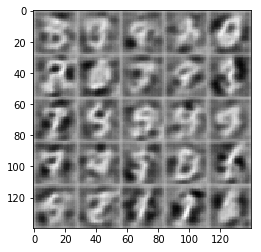

Epoch 2/2... Discriminator Loss: 0.7082... Generator Loss: 1.5924
Epoch 2/2... Discriminator Loss: 0.7542... Generator Loss: 1.5407
Epoch 2/2... Discriminator Loss: 0.8021... Generator Loss: 1.7570
Epoch 2/2... Discriminator Loss: 0.8317... Generator Loss: 1.6400
Epoch 2/2... Discriminator Loss: 0.7069... Generator Loss: 2.3501


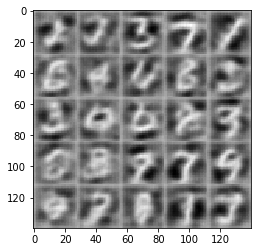

Epoch 2/2... Discriminator Loss: 0.7820... Generator Loss: 1.5577
Epoch 2/2... Discriminator Loss: 0.7508... Generator Loss: 1.8087
Epoch 2/2... Discriminator Loss: 0.7698... Generator Loss: 1.7634
Epoch 2/2... Discriminator Loss: 0.8483... Generator Loss: 1.7151
Epoch 2/2... Discriminator Loss: 0.7093... Generator Loss: 2.2992


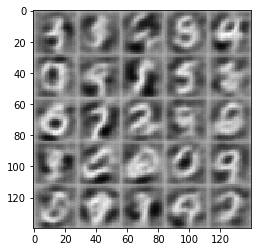

Epoch 2/2... Discriminator Loss: 1.0056... Generator Loss: 1.0197
Epoch 2/2... Discriminator Loss: 0.8550... Generator Loss: 1.2677
Epoch 2/2... Discriminator Loss: 0.8424... Generator Loss: 1.3152
Epoch 2/2... Discriminator Loss: 0.7274... Generator Loss: 1.5830
Epoch 2/2... Discriminator Loss: 0.9431... Generator Loss: 1.0838


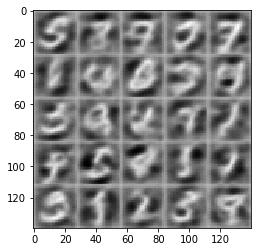

Epoch 2/2... Discriminator Loss: 0.8365... Generator Loss: 1.5348
Epoch 2/2... Discriminator Loss: 0.6401... Generator Loss: 1.7787
Epoch 2/2... Discriminator Loss: 0.7531... Generator Loss: 1.6191
Epoch 2/2... Discriminator Loss: 0.7808... Generator Loss: 1.4399
Epoch 2/2... Discriminator Loss: 0.9115... Generator Loss: 1.8110


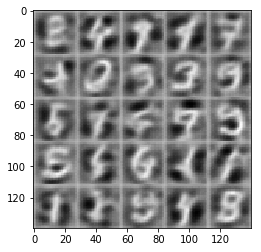

Epoch 2/2... Discriminator Loss: 0.6183... Generator Loss: 2.0640
Epoch 2/2... Discriminator Loss: 0.6606... Generator Loss: 1.9905
Epoch 2/2... Discriminator Loss: 0.7634... Generator Loss: 1.9226
Epoch 2/2... Discriminator Loss: 0.7612... Generator Loss: 1.7165
Epoch 2/2... Discriminator Loss: 0.9164... Generator Loss: 1.8397


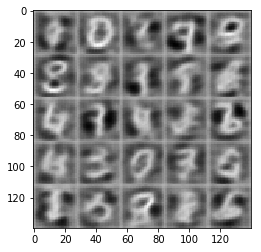

Epoch 2/2... Discriminator Loss: 0.7748... Generator Loss: 1.5325
Epoch 2/2... Discriminator Loss: 0.7401... Generator Loss: 1.6087
Epoch 2/2... Discriminator Loss: 0.7610... Generator Loss: 2.1362
Epoch 2/2... Discriminator Loss: 0.7810... Generator Loss: 1.3889
Epoch 2/2... Discriminator Loss: 0.8228... Generator Loss: 1.2833


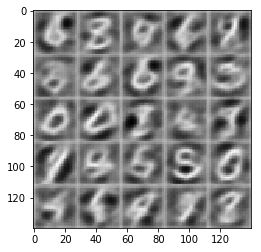

Epoch 2/2... Discriminator Loss: 0.8108... Generator Loss: 1.6082
Epoch 2/2... Discriminator Loss: 0.8607... Generator Loss: 1.7250
Epoch 2/2... Discriminator Loss: 0.8315... Generator Loss: 1.3945
Epoch 2/2... Discriminator Loss: 0.7490... Generator Loss: 2.3354
Epoch 2/2... Discriminator Loss: 1.1392... Generator Loss: 1.0782


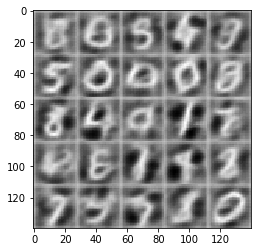

Epoch 2/2... Discriminator Loss: 0.8578... Generator Loss: 1.7237
Epoch 2/2... Discriminator Loss: 0.9051... Generator Loss: 1.1145
Epoch 2/2... Discriminator Loss: 0.7833... Generator Loss: 1.3005


In [13]:
batch_size = 64
z_dim = 100
learning_rate = .0001
beta1 = 0.8


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 4.6571
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 1.2183
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 1.3148
Epoch 1/1... Discriminator Loss: 0.5081... Generator Loss: 2.6176
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 1.8593


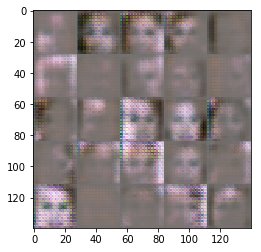

Epoch 1/1... Discriminator Loss: 2.0511... Generator Loss: 0.3066
Epoch 1/1... Discriminator Loss: 1.6836... Generator Loss: 0.4045
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.4557
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 1.6678
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.6574


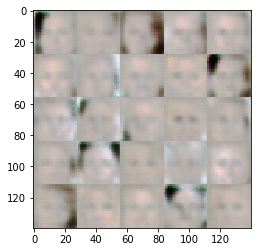

Epoch 1/1... Discriminator Loss: 1.9988... Generator Loss: 1.7887
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.9440


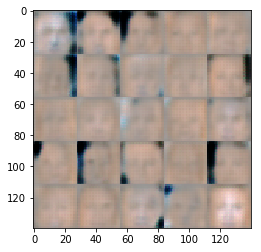

Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 1.1541
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.8322


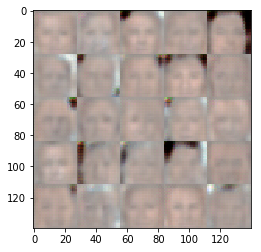

Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.3293
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.5385... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7820


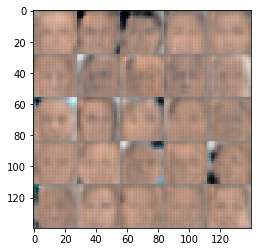

Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.9326


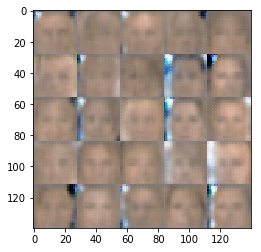

Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.6736


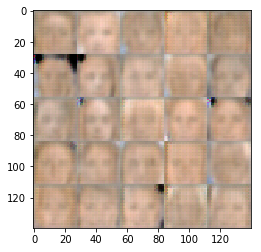

Epoch 1/1... Discriminator Loss: 1.6827... Generator Loss: 1.9455
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7484


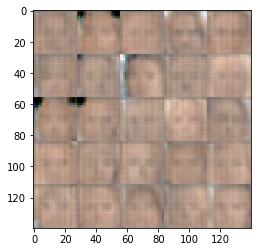

Epoch 1/1... Discriminator Loss: 2.5686... Generator Loss: 0.1193
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 1.1665
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7945


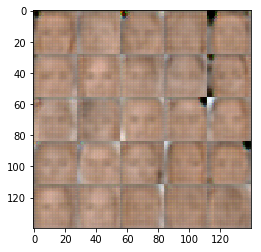

Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.8355


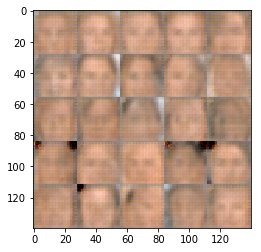

Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 1.2068
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.5255
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.6982


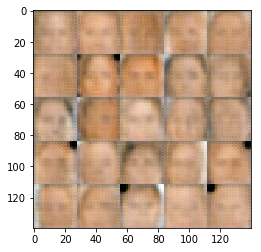

Epoch 1/1... Discriminator Loss: 1.6710... Generator Loss: 1.1062
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 1.3503
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.7780


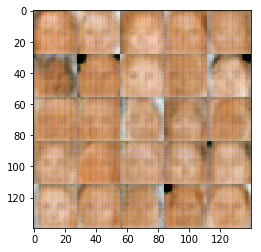

Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 1.3898
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.5980... Generator Loss: 0.3904


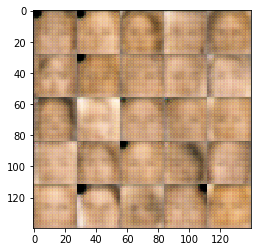

Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 1.2790
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 1.1256


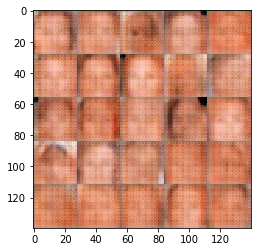

Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.8600


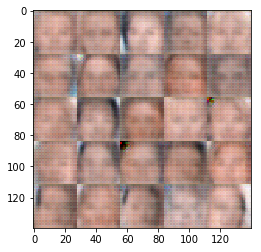

Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.6016... Generator Loss: 1.4482
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.8935


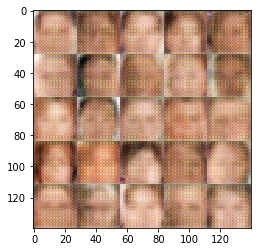

Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 1.1719
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.9524
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.5496


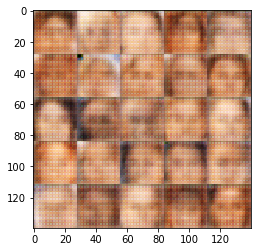

Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.8255


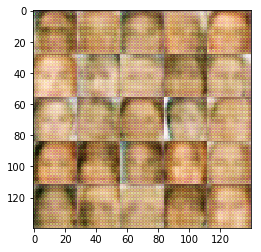

Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.9103


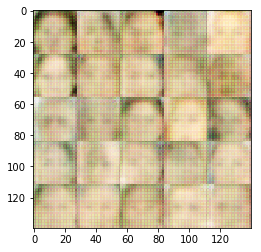

Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.6031


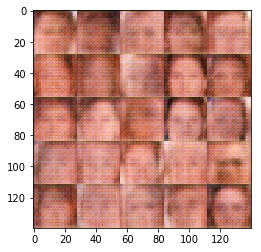

Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 1.0363
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.9159


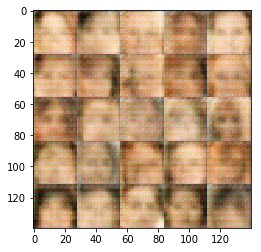

Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.7140


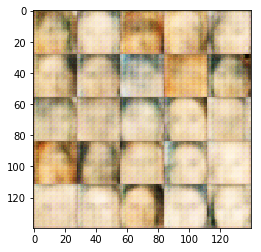

Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 1.1604
Epoch 1/1... Discriminator Loss: 1.9402... Generator Loss: 1.9575
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.9085


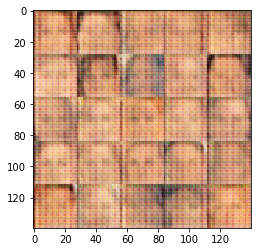

Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.9737
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.8373


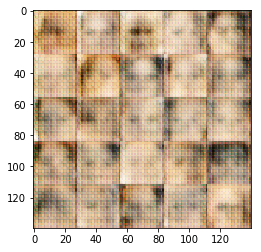

Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.8233


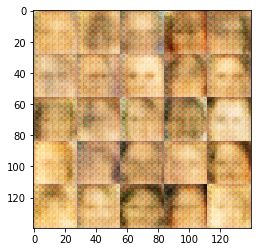

Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.2051
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.9433


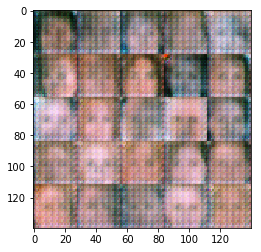

Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.9516


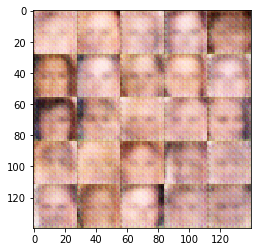

Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.8423


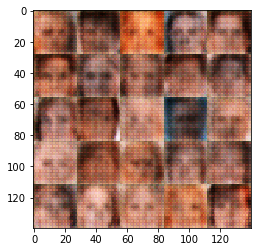

Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 1.0308
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.8889


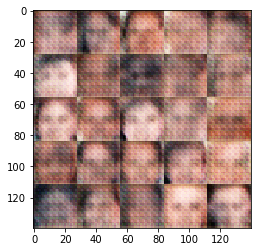

Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.5438


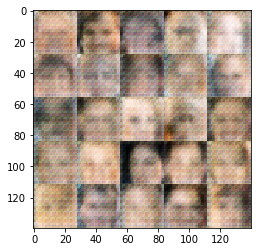

Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7275


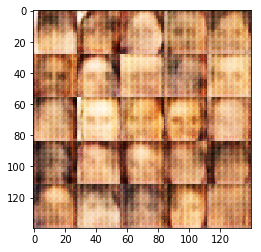

Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6814


In [17]:
batch_size = 64
z_dim = 100
learning_rate = .001
beta1 = .4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.